In [ ]:
!pip install pinard

## Combine predictors using Stacking

In this Notebook we will use multiple regressor to predict a data set.

## Loading data

In [2]:
# Standard loading and preprocessing code

from pinard import utils
from pinard.model_selection import train_test_split_idx
import numpy as np

# Init basic random
rd_seed = 42
np.random.seed(rd_seed)

xcal_csv = "https://raw.githubusercontent.com/GBeurier/pinard/main/examples/Xcal.csv"
ycal_csv = "https://raw.githubusercontent.com/GBeurier/pinard/main/examples/Ycal.csv"

# Create a set named data
x, y = utils.load_csv(xcal_csv, ycal_csv, x_hdr=0, y_hdr=0, remove_na=True)
train_index, test_index = train_test_split_idx(x, y=y, method="random", test_size=0.25, random_state=rd_seed)
X_train, y_train, X_test, y_test = x[train_index], y[train_index], x[test_index], y[test_index]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


from pinard import preprocessing as pp
from sklearn.pipeline import Pipeline

### Declare preprocessing pipeline components
preprocessing = [   ('id', pp.IdentityTransformer()),
                    ('savgol', pp.SavitzkyGolay()),
                    ('gaussian1', pp.Gaussian(order = 1, sigma = 2)),
                    ('gaussian2', pp.Gaussian(order = 2, sigma = 1)),
                    ('haar', pp.Wavelet('haar')),
                    ('savgol*savgol', Pipeline([('_sg1',pp.SavitzkyGolay()),('_sg2',pp.SavitzkyGolay())])),
                    ('gaussian1*savgol', Pipeline([('_g1',pp.Gaussian(order = 1, sigma = 2)),('_sg3',pp.SavitzkyGolay())])),
                    ('gaussian2*savgol', Pipeline([('_g2',pp.Gaussian(order = 1, sigma = 2)),('_sg4',pp.SavitzkyGolay())])),
                    ('haar*savgol', Pipeline([('_haar2',pp.Wavelet('haar')),('_sg5',pp.SavitzkyGolay())]))
                ]



(270, 2151) (270,) (91, 2151) (91,)


## Pipelines creation

Here we create the multiple pipelines and estimators for the stack

In [3]:
from xgboost import XGBRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV

from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import TransformedTargetRegressor

from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

union_pipeline = make_pipeline(MinMaxScaler(), FeatureUnion(preprocessing))

def get_estimator(regressor):
    pipeline = make_pipeline(union_pipeline, regressor)
    return TransformedTargetRegressor(regressor = pipeline, transformer = MinMaxScaler())

estimators = [
    # ("Random Forest", get_estimator( RandomForestRegressor(random_state=rd_seed) ) ),
    ("PLS", get_estimator( PLSRegression(n_components=20) ) ),
    ("PLS_small", get_estimator( PLSRegression(n_components=7) ) ),
    ("LassoCV", get_estimator( LassoCV() ) ),
    ("XGBoost", get_estimator( XGBRegressor() ) )
]


stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=RidgeCV())


NameError: name 'X' is not defined

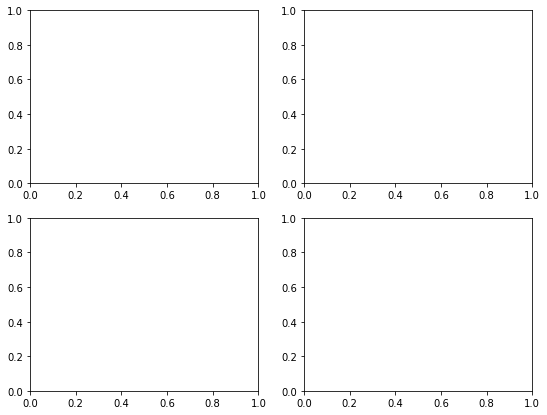

In [5]:
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, cross_val_predict


def plot_regression_results(ax, y_true, y_pred, title, scores, elapsed_time):
    """Scatter plot of the predicted vs true targets."""
    ax.plot(
        [y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "--r", linewidth=2
    )
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines["left"].set_position(("outward", 10))
    ax.spines["bottom"].set_position(("outward", 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel("Measured")
    ax.set_ylabel("Predicted")
    extra = plt.Rectangle(
        (0, 0), 0, 0, fc="w", fill=False, edgecolor="none", linewidth=0
    )
    ax.legend([extra], [scores], loc="upper left")
    title = title + "\n Evaluation in {:.2f} seconds".format(elapsed_time)
    ax.set_title(title)


fig, axs = plt.subplots(2, 2, figsize=(9, 7))
axs = np.ravel(axs)

for ax, (name, est) in zip(
    axs, estimators + [("Stacking Regressor", stacking_regressor)]
):
    start_time = time.time()
    score = cross_validate(
        est, x, y, cv=4, scoring=["r2", "neg_mean_absolute_error"], n_jobs=2, verbose=2
    )
    elapsed_time = time.time() - start_time

    y_pred = cross_val_predict(est, x, y, cv=4, n_jobs=2, verbose=1)

    plot_regression_results(
        ax,
        y,
        y_pred,
        name,
        (r"$R^2={:.2f} \pm {:.2f}$" + "\n" + r"$MAE={:.2f} \pm {:.2f}$").format(
            np.mean(score["test_r2"]),
            np.std(score["test_r2"]),
            -np.mean(score["test_neg_mean_absolute_error"]),
            np.std(score["test_neg_mean_absolute_error"]),
        ),
        elapsed_time,
    )

plt.suptitle("Single predictors versus stacked predictors")
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()